In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import keras

from collections import Counter
from imblearn.over_sampling import SMOTE 

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,f1_score,recall_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.applications import DenseNet121

import matplotlib.pyplot as plt

import pickle
import joblib
from joblib import dump, load

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [3]:
le = MyLabelEncoder()
le.fit(["No DR", "Mild", "Moderate", "Severe","Proliferative DR"])
dump(le, 'Project Assets/label_encoder.joblib') 

['Project Assets/label_encoder.joblib']

In [4]:
data_path="train_images/"
file = "train.csv"
image_size = 150

In [5]:
data = pd.read_csv(file)

In [6]:
#data = data.replace({0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe",4:"Proliferative DR"})

In [7]:
data = data.replace({0:"No DR", 1:"Mild DR", 2:"Mild DR", 3:"Clear DR",4:"Clear DR"})

In [8]:
output_nodes = len(set(list(data['diagnosis'])))

In [9]:
file_names=list(data['id_code'])

In [10]:
print(Counter(list(data['diagnosis'])))

Counter({'No DR': 1805, 'Mild DR': 1369, 'Clear DR': 488})


In [11]:
labels=data['diagnosis'].values.ravel()

In [12]:
def image_processing(data_path,file_names,img_size):
    dataset_tumor = []
    for file_name in file_names:
        file=cv2.imread(data_path+file_name+'.png', cv2.IMREAD_COLOR) 
        file_resize=cv2.resize(file,(img_size,img_size))/255.
        dataset_tumor.append(file_resize)
    tumor_data = np.array(dataset_tumor)
    tumor_data = tumor_data.reshape(-1,img_size,img_size,3)
    return tumor_data

In [13]:
#x = image_processing(data_path,file_names,image_size)
#np.save('Project Assets/x_image_data', x)

In [14]:
x = np.load('Project Assets/x_image_data.npy')

In [15]:
x_train_val,x_test,y_train_val,y_test = train_test_split(x,labels,test_size=0.2)

In [16]:
ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
ohe = ohe.fit(labels.reshape(-1,1))
y_train_val = ohe.transform(np.array(y_train_val).reshape(-1,1))
y_test = ohe.transform(np.array(y_test).reshape(-1,1))
dump(ohe, 'Project Assets/ohe_encoder.joblib') 

['Project Assets/ohe_encoder.joblib']

In [17]:
def build_VGG():
    model = Sequential()
    model.add(Conv2D(input_shape=(image_size,image_size,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=4096,activation="relu"))
    model.add(BatchNormalization())
    
    model.add(Dense(units=4096,activation="relu"))
    model.add(BatchNormalization())
    
    model.add(Dense(units=128, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(output_nodes, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['acc']
    )
    
    return model

In [18]:
model = build_VGG()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        3

In [19]:
def train_VGG(x_train_val, y_train_val):

    ohe = joblib.load('Project Assets/ohe_encoder.joblib')

    kf = KFold(n_splits=3,shuffle=True)
    k_number = 0
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1score = []
    
    
    print("VGG training with 3-Fold Cross Validation.")
    for train_index, test_index in kf.split(x_train_val):
        x_train, x_val = x_train_val[train_index], x_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]
        
        model = build_VGG()
        
        history1 = model.fit(x_train,y_train,epochs=15, validation_split = 0.2)
        
        acc_history = history1.history['acc']
        val_acc_history = history1.history['val_acc']
        loss_history = history1.history['loss']
        val_loss_history = history1.history['val_loss']
        
        plt.plot(history1.history['acc'])
        plt.plot(history1.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history1.history['loss'])
        plt.plot(history1.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        

        print("The highest validation acc is {}".format(np.max(val_acc_history)))
        
        result=model.predict(x_val)
        result_class = tf.one_hot(np.argmax(result, axis=1), depth = output_nodes)
        
        result_class = ohe.inverse_transform(result_class)
        y_val_class = ohe.inverse_transform(y_val)

        val_accuracy.append(accuracy_score(result_class, y_val_class))
        val_precision.append(precision_score(result_class, y_val_class,average='macro'))
        val_f1score.append(f1_score(result_class, y_val_class,average='macro'))
        val_recall.append(recall_score(result_class, y_val_class,average='macro'))

        average_val_accuracy=sum(val_accuracy)/len(val_accuracy)
        average_val_precision=sum(val_precision)/len(val_precision)
        average_val_recall=sum(val_recall)/len(val_recall)
        average_val_f1score=sum(val_f1score)/len(val_f1score)
        
        print("VGG 3-Fold CV:")
        print("Average Acc: %.4f" %(average_val_accuracy))
        print("Average Precision: %.4f" %(average_val_precision))
        print("Average recall: %.4f" %(average_val_recall))
        print("Average F1 Score: %.4f \n" %(average_val_f1score))
        
    model.save('Project Assets/VGG_Model')

VGG training with 3-Fold Cross Validation.
Epoch 1/15
49/49 [==============================] - 9s 83ms/step - loss: 1.1433 - acc: 0.5061 - val_loss: 1.1719 - val_acc: 0.3862
Epoch 2/15
49/49 [==============================] - 2s 50ms/step - loss: 0.7160 - acc: 0.7284 - val_loss: 0.8684 - val_acc: 0.5882
Epoch 3/15
49/49 [==============================] - 3s 52ms/step - loss: 0.6547 - acc: 0.7233 - val_loss: 1.3441 - val_acc: 0.6240
Epoch 4/15
49/49 [==============================] - 2s 50ms/step - loss: 0.6081 - acc: 0.7553 - val_loss: 0.8357 - val_acc: 0.7238
Epoch 5/15
49/49 [==============================] - 2s 50ms/step - loss: 0.5805 - acc: 0.7675 - val_loss: 0.7884 - val_acc: 0.7570
Epoch 6/15
49/49 [==============================] - 2s 48ms/step - loss: 0.5679 - acc: 0.7726 - val_loss: 0.5585 - val_acc: 0.7647
Epoch 7/15
49/49 [==============================] - 2s 48ms/step - loss: 0.5734 - acc: 0.7713 - val_loss: 0.6983 - val_acc: 0.7749
Epoch 8/15
49/49 [======================

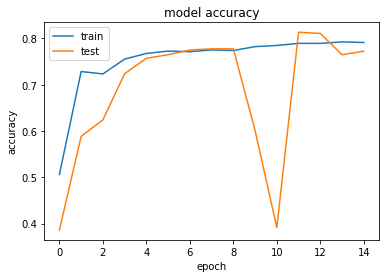

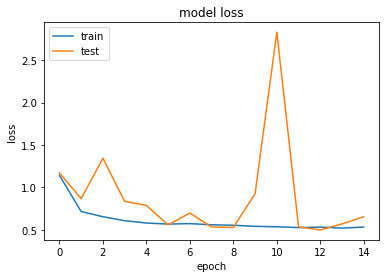

The highest validation acc is 0.8132992386817932
VGG 3-Fold CV:
Average Acc: 0.7625
Average Precision: 0.5900
Average recall: 0.5874
Average F1 Score: 0.5769 

Epoch 1/15
49/49 [==============================] - 4s 73ms/step - loss: 1.0805 - acc: 0.5122 - val_loss: 9.5577 - val_acc: 0.6010
Epoch 2/15
49/49 [==============================] - 2s 50ms/step - loss: 0.7244 - acc: 0.7222 - val_loss: 1.3473 - val_acc: 0.5627
Epoch 3/15
49/49 [==============================] - 2s 49ms/step - loss: 0.6577 - acc: 0.7510 - val_loss: 1.1787 - val_acc: 0.5243
Epoch 4/15
49/49 [==============================] - 2s 48ms/step - loss: 0.6130 - acc: 0.7586 - val_loss: 4.6509 - val_acc: 0.4962
Epoch 5/15
49/49 [==============================] - 2s 48ms/step - loss: 0.6070 - acc: 0.7676 - val_loss: 2.8453 - val_acc: 0.4962
Epoch 6/15
49/49 [==============================] - 2s 48ms/step - loss: 0.6200 - acc: 0.7490 - val_loss: 7.8362 - val_acc: 0.4962
Epoch 7/15
49/49 [==============================] - 2s

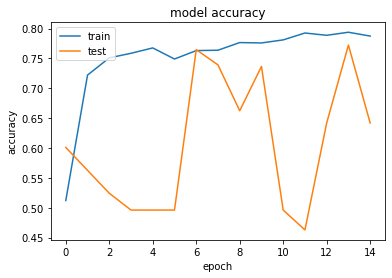

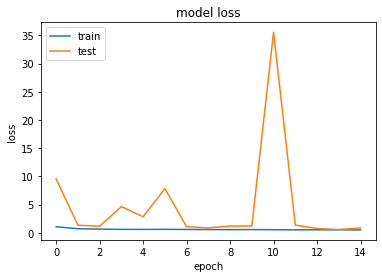

The highest validation acc is 0.7723785042762756
VGG 3-Fold CV:
Average Acc: 0.7127
Average Precision: 0.5763
Average recall: 0.5860
Average F1 Score: 0.5574 

Epoch 1/15
49/49 [==============================] - 3s 53ms/step - loss: 1.0582 - acc: 0.5685 - val_loss: 1.5162 - val_acc: 0.4629
Epoch 2/15
49/49 [==============================] - 2s 48ms/step - loss: 0.6749 - acc: 0.7458 - val_loss: 0.7842 - val_acc: 0.7647
Epoch 3/15
49/49 [==============================] - 2s 48ms/step - loss: 0.5778 - acc: 0.7823 - val_loss: 1.1784 - val_acc: 0.7161
Epoch 4/15
49/49 [==============================] - 2s 48ms/step - loss: 0.5814 - acc: 0.7862 - val_loss: 1.7640 - val_acc: 0.7059
Epoch 5/15
49/49 [==============================] - 2s 48ms/step - loss: 0.5463 - acc: 0.7990 - val_loss: 0.6435 - val_acc: 0.7903
Epoch 6/15
49/49 [==============================] - 2s 48ms/step - loss: 0.5536 - acc: 0.7964 - val_loss: 0.6418 - val_acc: 0.7852
Epoch 7/15
49/49 [==============================] - 2s

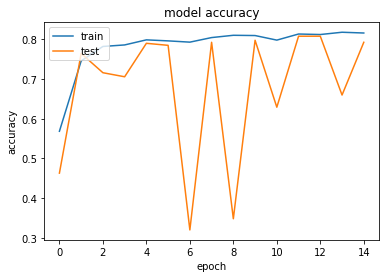

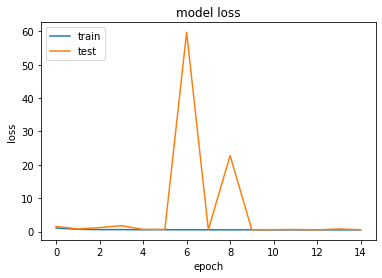

The highest validation acc is 0.8081841468811035
VGG 3-Fold CV:
Average Acc: 0.7354
Average Precision: 0.5904
Average recall: 0.5848
Average F1 Score: 0.5628 

INFO:tensorflow:Assets written to: Project Assets/VGG_Model\assets


In [20]:
train_VGG(x_train_val, y_train_val)

Accuracy for test data: 0.819918144611187


<Figure size 504x504 with 0 Axes>

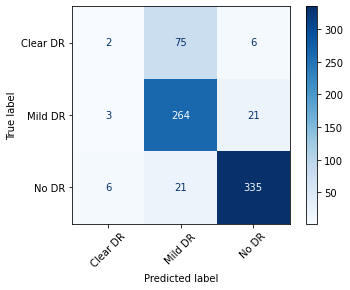

              precision    recall  f1-score   support

    Clear DR       0.18      0.02      0.04        83
     Mild DR       0.73      0.92      0.81       288
       No DR       0.93      0.93      0.93       362

    accuracy                           0.82       733
   macro avg       0.61      0.62      0.59       733
weighted avg       0.77      0.82      0.78       733



In [21]:
model = keras.models.load_model('Project Assets/VGG_Model')
ohe = joblib.load('Project Assets/ohe_encoder.joblib')

result=model.predict(x_test)
result_class = tf.one_hot(np.argmax(result, axis=1), depth = output_nodes)

result_class = ohe.inverse_transform(result_class)
y_test_class = ohe.inverse_transform(y_test)

acc = accuracy_score(result_class, y_test_class)
print("Accuracy for test data:", acc)

plt.figure(figsize = (7,7))
ConfusionMatrixDisplay.from_predictions(y_test_class, result_class, cmap = 'Blues')
plt.xticks(rotation=45)
plt.show()
print(classification_report(y_test_class, result_class))